In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

Data loading...
[Processing] Resampling to fix time gaps...

[Processing] Segmenting Cycles...

[Processing] Removing stabilization periods (v2: offset + strong smoothing)...

[Processing] Finalizing Features & Filtering Trends...
Final processing complete. Remaining rows: 13596


/tmp/ipython-input-562720428.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_start_after_gap = is_valid & (~is_valid.shift(1).fillna(False))
/tmp/ipython-input-562720428.py:132: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_trimmed = df_clean.groupby('Cycle_ID', group_keys=False).apply(keep_after_peak_v2)
/tmp/ipython-input-562720428.py:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version 

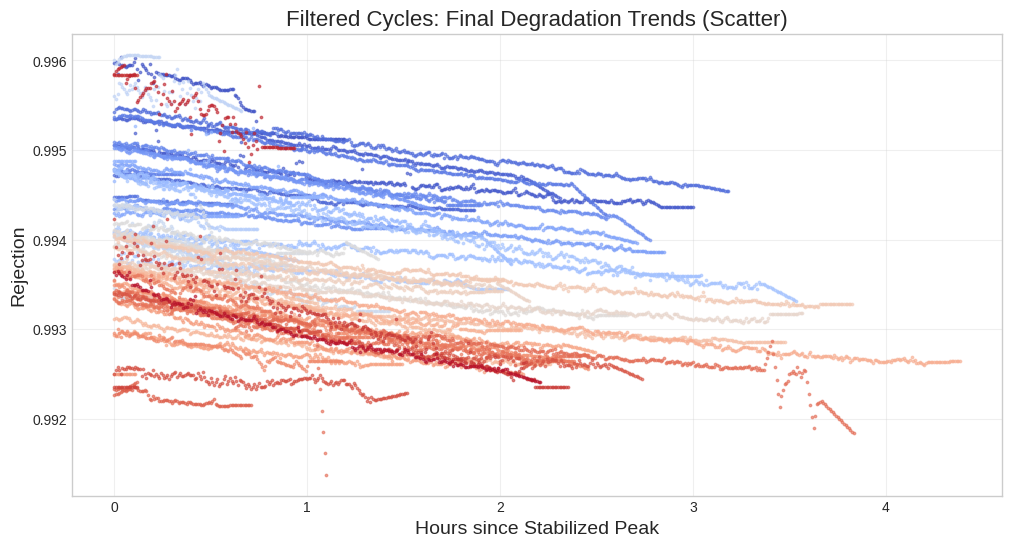

In [ ]:
# =============================================================================
# 1. SETUP & DATA LOADING
# =============================================================================
folder_path = '/content/'

columns_to_use = [
    "Date", "Time", "RTD 3 (c)", "RTD 4 (c)",
    "EC 1 (uS)", "EC 2 (uS)", "pH 5 ()", "pH 6 ()", "Status"
]

new_columns = [
    "Date", "Time", "Feed Temperature (Celsius)", "Permeate Temperature (Celsius)",
    "Feed Conductivity (uS/cm)", "Permeate Conductivity (uS/cm)",
    "Feed pH", "Permeate pH", "Status"
]

data_types = {
    "RTD 3 (c)": "float32", "RTD 4 (c)": "float32",
    "EC 1 (uS)": "float32", "EC 2 (uS)": "float32",
    "pH 5 ()": "float32", "pH 6 ()": "float32",
    "Status": "category"
}

numeric_cols_new_names = [
    "Feed Temperature (Celsius)", "Permeate Temperature (Celsius)",
    "Feed Conductivity (uS/cm)", "Permeate Conductivity (uS/cm)",
    "Feed pH", "Permeate pH"
]

out_multi_factor = 1.0

def process_files_iteratively(files):
    for file in files:
        yield pd.read_csv(file, usecols=columns_to_use, dtype=data_types, na_values=['nan', 'NA', 'missing'])

def remove_outliers_iqr(group):
    mask = pd.Series(True, index=group.index)
    for col in numeric_cols_new_names:
        Q1, Q3 = group[col].quantile(0.25), group[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - out_multi_factor * IQR, Q3 + out_multi_factor * IQR
        mask &= group[col].between(lower_bound, upper_bound)
    return group.loc[mask]

print("Data loading...")

df_recycle = (
    pd.concat(process_files_iteratively(glob.glob(os.path.join(folder_path, "*.csv"))), ignore_index=True)
    .dropna()
    .assign(Status=lambda df: df['Status'].str.strip())
    .rename(columns=dict(zip(columns_to_use, new_columns)))
    .query("Status == 'Recycle Loop'")
    .loc[lambda df: ~((df["Feed Temperature (Celsius)"] > 35) | (df["Permeate Temperature (Celsius)"] > 35))]
    .loc[lambda df: ~((df["Permeate Conductivity (uS/cm)"] > 10000))]
    .loc[lambda df: df["Feed pH"].between(0, 14) & df["Permeate pH"].between(0, 14)]
    .pipe(remove_outliers_iqr)
    .copy(deep=True)
)

df_recycle['DateTime'] = pd.to_datetime(df_recycle['Date'] + ' ' + df_recycle['Time'], errors='coerce')
df_recycle = df_recycle.set_index('DateTime').sort_index().drop(columns=['Date', 'Time'])

# =============================================================================
# 2. RESAMPLING & INTERPOLATION
# =============================================================================
print("[Processing] Resampling to fix time gaps...")

# Remove duplicate indices
df_recycle = df_recycle[~df_recycle.index.duplicated(keep='first')]

# Resample to 30s intervals
# limit=20: Fill gaps up to 10 mins, leave larger gaps (device off) as NaN
df_recycle = df_recycle.resample('30s').asfreq()
df_recycle[numeric_cols_new_names] = df_recycle[numeric_cols_new_names].interpolate(method='time', limit=20)

# Fill Status
if 'Status' in df_recycle.columns:
    df_recycle['Status'] = df_recycle['Status'].ffill(limit=15)

# Rejection Calculation (Corrected)
# Results will be NaN where input data is NaN
df_recycle['rejection_corrected'] = 1 - (
    (df_recycle['Permeate Conductivity (uS/cm)'] / 10000) /
    ((298.15 / (df_recycle['Permeate Temperature (Celsius)'] + 273.15)) * (1.1543e-19 * ((df_recycle['Permeate Temperature (Celsius)'] + 273.15) ** 7.7358) * 1e9 / 1.612e9))
) / (
    (df_recycle['Feed Conductivity (uS/cm)'] / 10000) /
    ((298.15 / (df_recycle['Feed Temperature (Celsius)'] + 273.15)) * (1.1543e-19 * ((df_recycle['Feed Temperature (Celsius)'] + 273.15) ** 7.7358) * 1e9 / 1.612e9))
)

# =============================================================================
# 3. SMART SEGMENTATION & NOISE FILTERING
# =============================================================================
print("\n[Processing] Segmenting Cycles...")

# 1. Detect Gaps: Start new cycle if data resumes after a gap (NaN)
is_valid = ~df_recycle['rejection_corrected'].isna()
is_start_after_gap = is_valid & (~is_valid.shift(1).fillna(False))

# 2. Detect Performance Jumps (Sudden increase in rejection)
df_recycle['rejection_smooth'] = df_recycle['rejection_corrected'].rolling(window=5, min_periods=1).mean()
is_perf_jump = (df_recycle['rejection_smooth'] - df_recycle['rejection_smooth'].shift(1)) > 0.001

# 3. Assign Cycle ID
df_recycle['Cycle_ID'] = (is_start_after_gap | is_perf_jump).fillna(False).cumsum()

# 4. Remove NaN rows (Keep only valid data for training)
df_recycle = df_recycle.dropna(subset=['rejection_corrected'])

MIN_ROWS_PER_CYCLE = 30
valid_cycles = df_recycle['Cycle_ID'].value_counts()[lambda x: x >= MIN_ROWS_PER_CYCLE].index
df_clean = df_recycle[df_recycle['Cycle_ID'].isin(valid_cycles)].copy()

# =============================================================================
# 4. STABILIZATION REMOVAL
# =============================================================================
print("\n[Processing] Removing stabilization periods (v2: offset + strong smoothing)...")

def keep_after_peak_v2(group):
    offset = 15
    if len(group) <= offset:
        return group

    # Ignore the very first part to avoid false initial peaks
    search_area = group.iloc[offset:]

    # Apply strong smoothing to find the true stabilized peak
    smooth_vals = search_area['rejection_corrected'].rolling(window=30, center=True, min_periods=1).mean()

    # Search for peak within the first 70% of the cycle
    search_limit = int(len(search_area) * 0.7)
    peak_idx = smooth_vals.iloc[:search_limit].idxmax()

    return group.loc[peak_idx:]

df_trimmed = df_clean.groupby('Cycle_ID', group_keys=False).apply(keep_after_peak_v2)

# Remap Cycle IDs to be consecutive
old_id_map = {old: new for new, old in enumerate(sorted(df_trimmed['Cycle_ID'].unique()), 1)}
df_trimmed['Cycle_ID'] = df_trimmed['Cycle_ID'].map(old_id_map)

# =============================================================================
# 5. FEATURE ENGINEERING & TREND FILTERING
# =============================================================================
print("\n[Processing] Finalizing Features & Filtering Trends...")

def get_time_and_filter(group):
    start_time = group.index[0]
    group['Time_in_Cycle_minutes'] = (group.index - start_time).total_seconds() / 60

    # Trend Filtering: Remove cycles that are still increasing (not degrading)
    if len(group) > 40:
        start_avg = group['rejection_corrected'].iloc[:10].mean()
        end_avg = group['rejection_corrected'].iloc[-10:].mean()
        if end_avg > start_avg:
            return None

    return group

df_final = df_trimmed.groupby('Cycle_ID', group_keys=False).apply(get_time_and_filter)
df_final = df_final.dropna(subset=['Cycle_ID'])
df_final['Rejection_Raw'] = df_final['rejection_corrected']

print(f"Final processing complete. Remaining rows: {len(df_final)}")

# =============================================================================
# 6. VISUALIZATION (SCATTER PLOT)
# =============================================================================
plt.figure(figsize=(12, 6))
unique_cycles = sorted(df_final['Cycle_ID'].unique())
colors = sns.color_palette("coolwarm", len(unique_cycles))

for i, cid in enumerate(unique_cycles):
    subset = df_final[df_final['Cycle_ID'] == cid]
    plt.scatter(
        subset['Time_in_Cycle_minutes'] / 60,
        subset['Rejection_Raw'],
        color=colors[i],
        alpha=0.6,
        s=3,
        label=f'Cycle {cid}' if len(unique_cycles) <= 10 else None
    )

plt.title("Filtered Cycles: Final Degradation Trends (Scatter)", fontsize=16)
plt.xlabel("Hours since Stabilized Peak", fontsize=14)
plt.ylabel("Rejection", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


[Processing] Calculating slopes for each cycle...

--- Cycle Slope Summary (Top 10) ---
   Cycle_ID     Slope  Intercept        R2  Duration_Hours
0         1 -0.000894   0.996059  0.923598        1.191667
1         2 -0.000225   0.994988  0.918202        3.000000
2         3 -0.000344   0.995394  0.986124        2.308333
3         4 -0.000234   0.994721  0.973753        1.866667
4         5 -0.000285   0.995442  0.993106        3.183333
5         6 -0.000140   0.994472  0.822722        0.608333
6         7 -0.000364   0.995383  0.982136        2.550000
7         8 -0.000183   0.994778  0.804035        0.350000
8         9 -0.000405   0.995110  0.993555        1.891667
9        10 -0.000303   0.994984  0.974656        2.775000


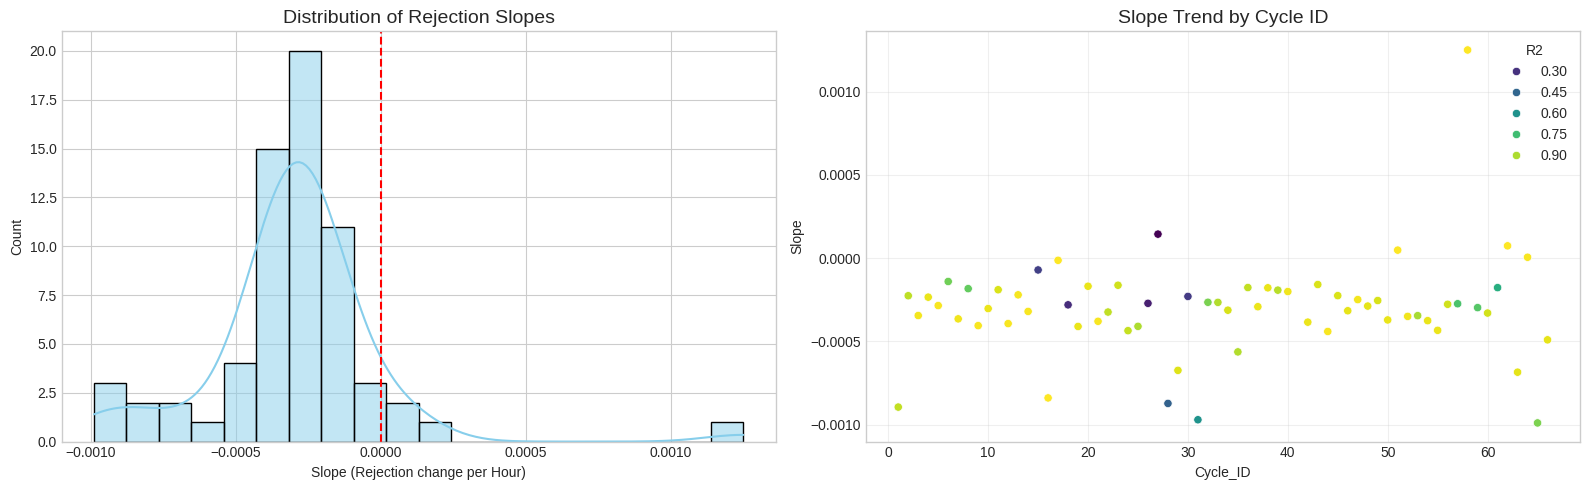


[Result] Average Slope across all cycles: -0.000302 Rejection/Hour
------------------------------------------------------------
[Filtering Report] Threshold: R2 < 0.5
 - Removed Cycles : 6 cycles [np.int64(15), np.int64(18), np.int64(26), np.int64(27), np.int64(28), np.int64(30)]
 - Removed Rows   : 405 rows
------------------------------------------------------------
[Average Slope Comparison]
 1. Before Filtering : -0.00030195 Rejection/Hour
 2. After Filtering  : -0.00030589 Rejection/Hour
 -> Change           : -1.31%
------------------------------------------------------------


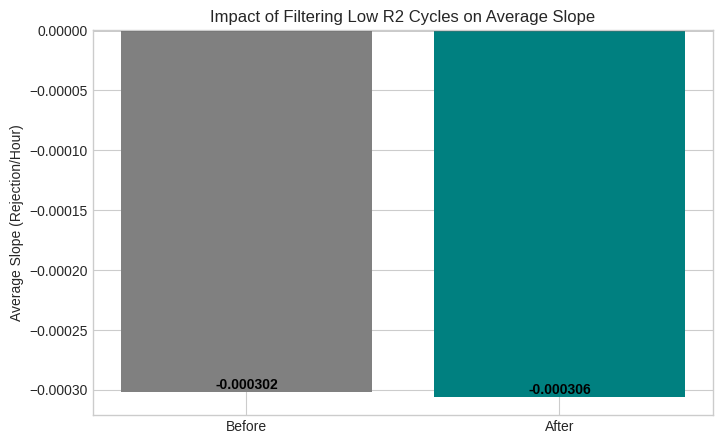


[Complete] 'df_final' has been updated with cleaned data.


In [ ]:
# =============================================================================
# 7. CALCULATE LINEAR SLOPES PER CYCLE
# =============================================================================
print("\n[Processing] Calculating slopes for each cycle...")

slope_results = []

for cid in sorted(df_final['Cycle_ID'].unique()):
    subset = df_final[df_final['Cycle_ID'] == cid]

    # X: Time (Hours), y: Rejection
    X = (subset['Time_in_Cycle_minutes'] / 60).values.reshape(-1, 1)
    y = subset['Rejection_Raw'].values

    if len(X) > 1:
        model = LinearRegression()
        model.fit(X, y)

        slope = model.coef_[0]        # Slope (Change in Rejection per Hour)
        intercept = model.intercept_   # Intercept
        r_squared = model.score(X, y)  # R-squared (Linearity confidence)

        slope_results.append({
            'Cycle_ID': cid,
            'Slope': slope,
            'Intercept': intercept,
            'R2': r_squared,
            'Duration_Hours': X.max()
        })

# Create Slope DataFrame
df_slopes = pd.DataFrame(slope_results)

print("\n--- Cycle Slope Summary (Top 10) ---")
print(df_slopes.head(10))

# =============================================================================
# 8. SLOPE VISUALIZATION & FILTERING
# =============================================================================
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# A. Distribution of Slopes
sns.histplot(df_slopes['Slope'], bins=20, kde=True, ax=ax[0], color='skyblue')
ax[0].axvline(0, color='red', linestyle='--')
ax[0].set_title("Distribution of Rejection Slopes", fontsize=14)
ax[0].set_xlabel("Slope (Rejection change per Hour)")

# B. Slope Trend by Cycle (Aging Effect)
sns.scatterplot(data=df_slopes, x='Cycle_ID', y='Slope', hue='R2', palette='viridis', ax=ax[1])
ax[1].set_title("Slope Trend by Cycle ID", fontsize=14)
ax[1].set_ylabel("Slope")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate Average Slope
avg_slope = df_slopes['Slope'].mean()
print(f"\n[Result] Average Slope across all cycles: {avg_slope:.6f} Rejection/Hour")

# -----------------------------------------------------------------------------
# FILTER LOW R2 CYCLES
# -----------------------------------------------------------------------------
# 1. Identify bad cycles based on R2
r2_threshold = 0.5
bad_cycles = df_slopes[df_slopes['R2'] < r2_threshold]['Cycle_ID'].unique()

# 2. Clean DataFrames
df_slopes_clean = df_slopes[~df_slopes['Cycle_ID'].isin(bad_cycles)].copy()
original_rows = len(df_final)
df_final_clean = df_final[~df_final['Cycle_ID'].isin(bad_cycles)].copy()

# 3. Compare Results
avg_slope_before = df_slopes['Slope'].mean()
avg_slope_after = df_slopes_clean['Slope'].mean()
change_pct = ((avg_slope_after - avg_slope_before) / abs(avg_slope_before)) * 100

print("-" * 60)
print(f"[Filtering Report] Threshold: R2 < {r2_threshold}")
print(f" - Removed Cycles : {len(bad_cycles)} cycles {list(bad_cycles)}")
print(f" - Removed Rows   : {original_rows - len(df_final_clean)} rows")
print("-" * 60)
print(f"[Average Slope Comparison]")
print(f" 1. Before Filtering : {avg_slope_before:.8f} Rejection/Hour")
print(f" 2. After Filtering  : {avg_slope_after:.8f} Rejection/Hour")
print(f" -> Change           : {change_pct:.2f}%")
print("-" * 60)

# Update main dataframe
df_final = df_final_clean
print("\n[Complete] 'df_final' has been updated with cleaned data.")

In [ ]:
# =============================================================================
# 9. ADDITIONAL FEATURES FOR LSTM
# =============================================================================
print("\n[Processing] Generating additional features for LSTM...")

# 1. Total_Cumulative_Hours (Aging Indicator)
# Calculate hours elapsed since the start of the entire dataset
start_time_global = df_final.index.min()
df_final['Total_Cumulative_Hours'] = (df_final.index - start_time_global).total_seconds() / 3600

# 2. Rejection_Diff (Target Variable)
# Calculate difference from the previous time step
df_final['Rejection_Diff'] = df_final['Rejection_Raw'].diff()

# Drop first row (NaN due to diff)
df_final = df_final.dropna(subset=['Rejection_Diff'])

print(f"Features created. 'Total_Cumulative_Hours' max: {df_final['Total_Cumulative_Hours'].max():.2f} hours")


[Processing] Generating additional features for LSTM...
Features created. 'Total_Cumulative_Hours' max: 2876.74 hours



[Modeling] Preparing Data for LSTM (Cycle-based Split)...
Train Cycles: 47개 (1 ~ 54)
Test Cycles:  12개 (55 ~ 66)
Generating sequences (look_back=30)...
Train Sequences: 9472 | Test Sequences: 2034
Input Shape: (9472, 30, 2) (Batch, Time, Features)

[Modeling] Starting Training on cuda...


/tmp/ipython-input-2062399580.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Rejection_Diff'] = df_final.groupby('Cycle_ID')['rejection_corrected'].diff().fillna(0)


Epoch [1/20] - Loss: 0.00341938
Epoch [2/20] - Loss: 0.00233934
Epoch [3/20] - Loss: 0.00233099
Epoch [4/20] - Loss: 0.00232962
Epoch [5/20] - Loss: 0.00234015
Epoch [6/20] - Loss: 0.00233106
Epoch [7/20] - Loss: 0.00233955
Epoch [8/20] - Loss: 0.00235735
Epoch [9/20] - Loss: 0.00235093
Epoch [10/20] - Loss: 0.00234801
Epoch [11/20] - Loss: 0.00233728
Epoch [12/20] - Loss: 0.00233701
Epoch [13/20] - Loss: 0.00233169
Epoch [14/20] - Loss: 0.00233375
Epoch [15/20] - Loss: 0.00232881
Epoch [16/20] - Loss: 0.00233162
Epoch [17/20] - Loss: 0.00234250
Epoch [18/20] - Loss: 0.00233306
Epoch [19/20] - Loss: 0.00232998
Epoch [20/20] - Loss: 0.00233391


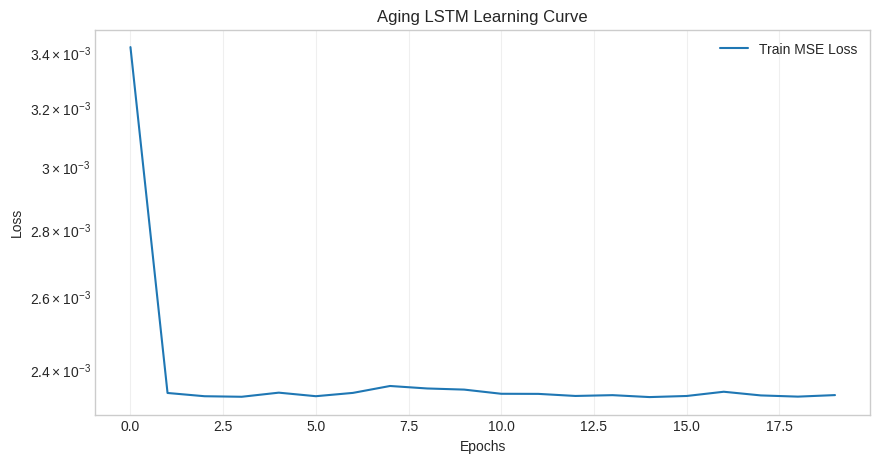

In [ ]:
# =============================================================================
# 10. LSTM MODEL PREPARATION & TRAINING
# =============================================================================
print("\n[Modeling] Preparing Data for LSTM (Cycle-based Split)...")

# 0. Ensure Target Exists (Per Cycle Diff)
df_final['Rejection_Diff'] = df_final.groupby('Cycle_ID')['rejection_corrected'].diff().fillna(0)

features = ['Time_in_Cycle_minutes', 'Total_Cumulative_Hours']
target = ['Rejection_Diff']

# 1. Train/Test Split by Cycle_ID (Prevent Data Leakage)
unique_cycles = sorted(df_final['Cycle_ID'].unique())
split_point = int(len(unique_cycles) * 0.8)

train_cycles = unique_cycles[:split_point]
test_cycles = unique_cycles[split_point:]

print(f"Train Cycles: {len(train_cycles)} ({train_cycles[0]} ~ {train_cycles[-1]})")
print(f"Test Cycles:  {len(test_cycles)} ({test_cycles[0]} ~ {test_cycles[-1]})")

train_df = df_final[df_final['Cycle_ID'].isin(train_cycles)].copy()
test_df = df_final[df_final['Cycle_ID'].isin(test_cycles)].copy()

# 2. Scaling (Fit on Train only)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_train_raw = train_df[features].values
y_train_raw = train_df[target].values

scaler_X.fit(X_train_raw)
scaler_y.fit(y_train_raw)

# Transform both Train and Test
train_df[features] = scaler_X.transform(X_train_raw)
train_df[target] = scaler_y.transform(y_train_raw)

test_df[features] = scaler_X.transform(test_df[features].values)
test_df[target] = scaler_y.transform(test_df[target].values)

# 3. Sequence Generation Function (Cycle-aware)
# Creates sequences within each cycle to avoid boundary artifacts
def create_sequences_by_cycle(df, cycle_ids, features, target, look_back):
    X_list, y_list = [], []

    for cycle in cycle_ids:
        cycle_data = df[df['Cycle_ID'] == cycle]

        if len(cycle_data) <= look_back:
            continue

        data_x = cycle_data[features].values
        data_y = cycle_data[target].values

        for i in range(len(data_x) - look_back):
            X_list.append(data_x[i:(i + look_back)])
            y_list.append(data_y[i + look_back])

    return np.array(X_list), np.array(y_list)

look_back = 30
print(f"Generating sequences (look_back={look_back})...")

X_train_seq, y_train_seq_np = create_sequences_by_cycle(train_df, train_cycles, features, target, look_back)
X_test_seq, y_test_seq_np = create_sequences_by_cycle(test_df, test_cycles, features, target, look_back)

# 4. Convert to Tensors
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq_np)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq_np)

# 5. Create DataLoaders
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

print(f"Train Sequences: {len(X_train_seq)} | Test Sequences: {len(X_test_seq)}")

# =============================================================================
# LSTM MODEL DEFINITION
# =============================================================================
class AgingLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        # Use only the last time step
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgingLSTM(input_size=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# =============================================================================
# TRAINING LOOP
# =============================================================================
print(f"\n[Modeling] Starting Training on {device}...")
epochs = 20
loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.8f}")

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Train MSE Loss')
plt.title('Aging LSTM Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


[Evaluation] Predicting on Test Set...


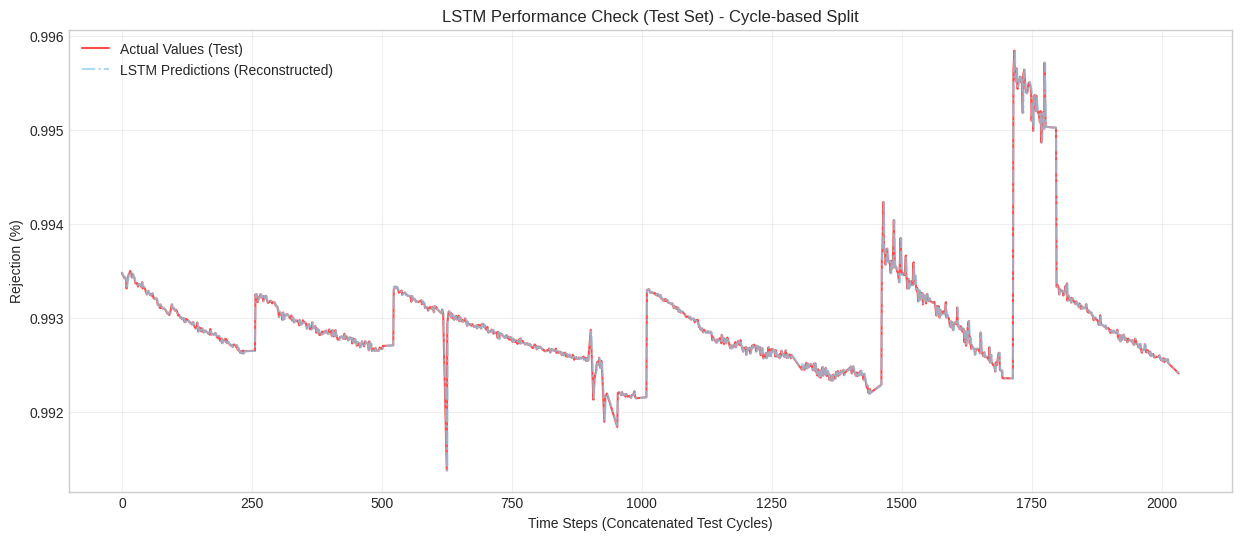

Test MSE: 0.000000


In [ ]:
# =============================================================================
# 11. EVALUATION (TEST SET)
# =============================================================================
print("\n[Evaluation] Predicting on Test Set...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

test_preds_scaled = []

# 1. Model Prediction (Scaled Diff)
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        test_preds_scaled.append(pred.cpu())

test_preds_scaled = torch.cat(test_preds_scaled).numpy()

# Inverse Transform to get actual Diff
test_preds_diff = scaler_y.inverse_transform(test_preds_scaled)

# 2. Extract Raw Values for Reconstruction
test_raw_current = [] # y[t]: Actual value (for comparison)
test_raw_prev = []    # y[t-1]: Previous actual value (for reconstruction)

for cycle in test_cycles:
    cycle_data = test_df[test_df['Cycle_ID'] == cycle]
    if len(cycle_data) <= look_back:
        continue

    raw_vals = cycle_data['Rejection_Raw'].values

    for i in range(len(raw_vals) - look_back):
        test_raw_current.append(raw_vals[i + look_back])
        test_raw_prev.append(raw_vals[i + look_back - 1])

actual_raw_test = np.array(test_raw_current).reshape(-1, 1)
prev_raw_test = np.array(test_raw_prev).reshape(-1, 1)

# 3. Reconstruct Values: Pred_Value = Prev_Actual + Pred_Diff
pred_raw_reconstructed = prev_raw_test + test_preds_diff

# 4. Visualization
plt.figure(figsize=(15, 6))
plt.plot(actual_raw_test, label='Actual Values (Test)', color='red', alpha=0.7)
plt.plot(pred_raw_reconstructed, label='LSTM Predictions (Reconstructed)', color='skyblue', alpha=0.7, linestyle='-.')
plt.title("LSTM Performance Check (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Rejection")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

mse = np.mean((actual_raw_test - pred_raw_reconstructed)**2)
print(f"Test MSE: {mse:.6f}")

final_predictions = pred_raw_reconstructed


[Diagnosis] Running Multi-step Forecast Test (Blind Prediction)...


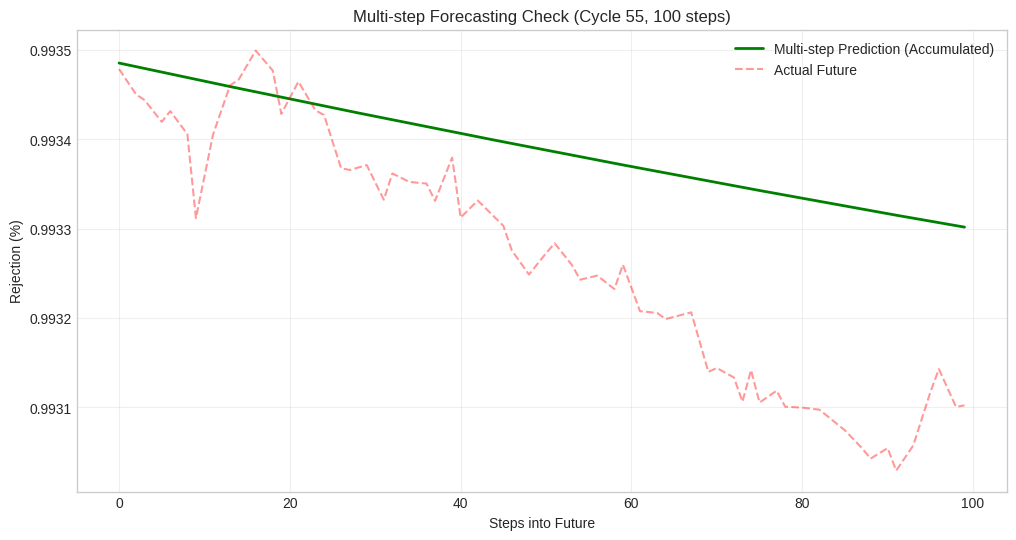

In [ ]:
# =============================================================================
# 12. MULTI-STEP FORECASTING TEST
# =============================================================================
print("\n[Diagnosis] Running Multi-step Forecast Test (Blind Prediction)...")

# 1. Select Target Cycle for Testing (First cycle of test set)
target_cycle_id = test_cycles[0]
target_cycle_data = df_final[df_final['Cycle_ID'] == target_cycle_id]
target_raw_values = target_cycle_data['Rejection_Raw'].values

# 2. Setup Parameters
start_idx = 0
steps_to_check = 100
steps_to_check = min(steps_to_check, len(target_raw_values) - look_back)

# Initial value for reconstruction
current_val = target_raw_values[look_back + start_idx - 1]

multi_step_preds = []
model.eval()

with torch.no_grad():
    for i in range(steps_to_check):
        if start_idx + i >= len(X_test_seq):
            break

        # Get current sequence
        current_seq_np = X_test_seq[start_idx + i]
        current_seq = torch.FloatTensor(current_seq_np).unsqueeze(0).to(device)

        # Predict Scaled Diff
        pred_diff_scaled = model(current_seq)

        # Inverse Scale & Accumulate
        pred_diff = scaler_y.inverse_transform(pred_diff_scaled.cpu().numpy())[0, 0]
        next_val = current_val + pred_diff

        multi_step_preds.append(next_val)
        current_val = next_val

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(multi_step_preds, label='Multi-step Prediction (Accumulated)', color='green', linewidth=2)

actual_future = target_raw_values[look_back + start_idx : look_back + start_idx + len(multi_step_preds)]
plt.plot(actual_future, label='Actual Future', color='red', alpha=0.4, linestyle='--')

plt.title(f"Multi-step Forecasting Check (Cycle {target_cycle_id})")
plt.xlabel("Steps into Future")
plt.ylabel("Rejection")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


--- [Method 2] Physics-based Curve Fitting & Extrapolation ---
Fitting physics model to the last 203 points of LSTM predictions...
Fitting Successful!
Estimated Parameters: a=9.9320e-01, b=9.7366e-06, c=0.8187

[Result] Threshold (0.99) reached in 985 steps.
Final Value: 0.9900


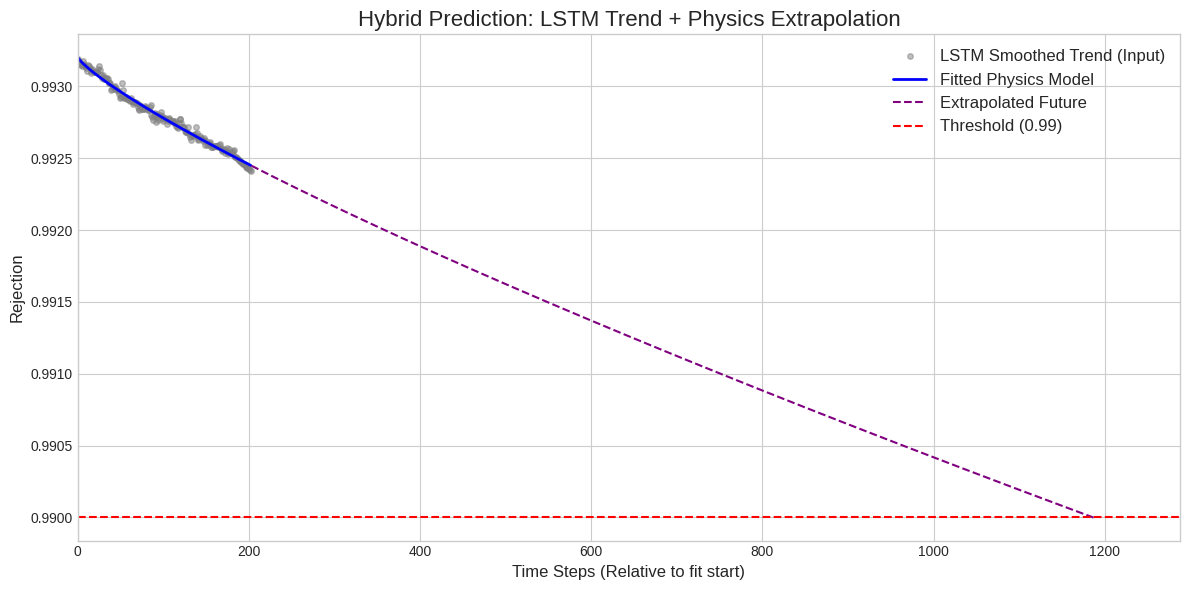


--- Time Estimation ---
Reference Time (Last Data): 2025-11-04 12:15:00
Predicted Remaining Useful Life (RUL): 8.21 hours
Predicted Failure Date: 2025-11-04 20:27:30


In [ ]:
# =============================================================================
# 13. HYBRID PREDICTION: CURVE FITTING & EXTRAPOLATION (With 95% CI)
# =============================================================================
print("\n--- [Method] Physics-based Curve Fitting & Extrapolation (with CI) ---")

# 1. Configuration
threshold = 0.990   # Failure Threshold
fit_lookback = int(len(final_predictions) * 0.1)   # Use last 10% of LSTM predictions for fitting

# Power Law Model: y = a - b * (t ^ c)
def fouling_model(t, a, b, c):
    return a - b * (t ** c)

# 2. Data Preparation
y_trend = final_predictions[-fit_lookback:].flatten()
x_trend = np.arange(len(y_trend))

print(f"Fitting physics model to the last {fit_lookback} points of LSTM predictions...")

popt = None
pcov = None
lower_ci, upper_ci = None, None

try:
    # Initial Guesses & Bounds
    initial_guess = [0.05, 0.0001, 0.95]
    lower_bounds = [0, 1e-9, 0]
    upper_bounds = [np.inf, np.inf, 1.5]

    # Curve Fitting
    popt, pcov = curve_fit(
        fouling_model, x_trend, y_trend,
        p0=initial_guess,
        bounds=(lower_bounds, upper_bounds),
        maxfev=10000
    )

    print(f"Fitting Successful!")
    print(f"Estimated Parameters: a={popt[0]:.4e}, b={popt[1]:.4e}, c={popt[2]:.4f}")

except Exception as e:
    print(f"Fitting Failed: {e}")
    popt = None

# 3. Future Extrapolation & CI
steps_to_threshold = -1
forecast_plot_values = []
max_forecast_steps = 400000
start_t = len(y_trend)

if popt is not None:
    # (A) Mean Prediction
    future_steps_range = np.arange(start_t, start_t + max_forecast_steps)
    forecast_plot_values = fouling_model(future_steps_range, *popt)

    # Check Threshold
    reached_indices = np.where(forecast_plot_values <= threshold)[0]

    if len(reached_indices) > 0:
        first_reach_idx = reached_indices[0]
        steps_to_threshold = first_reach_idx + 1

        # Cut off for visualization
        display_margin = 1000
        cut_idx = first_reach_idx + display_margin
        forecast_plot_values = forecast_plot_values[:cut_idx]
        future_steps_range = future_steps_range[:cut_idx]

        print(f"\n[Result] Threshold ({threshold}) reached in {steps_to_threshold} steps.")
    else:
        print(f"\n[Result] Threshold not reached within {max_forecast_steps} steps.")

    # (B) 95% Confidence Interval (Monte Carlo Simulation)
    print("Calculating 95% Confidence Intervals...")
    num_samples = 500
    try:
        params_samples = np.random.multivariate_normal(popt, pcov, num_samples)
        simulated_curves = []
        for params in params_samples:
            if (np.any(params < lower_bounds) or np.any(params > upper_bounds)):
                continue
            sim_curve = fouling_model(future_steps_range, *params)
            simulated_curves.append(sim_curve)

        if len(simulated_curves) > 0:
            simulated_curves = np.array(simulated_curves)
            lower_ci = np.percentile(simulated_curves, 2.5, axis=0)
            upper_ci = np.percentile(simulated_curves, 97.5, axis=0)
    except Exception as e:
        print(f"CI Calculation Warning: {e}")

# 4. Visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

# LSTM Trend
ax.plot(range(len(y_trend)), y_trend, 'o', color='gray', label='LSTM Smoothed Trend', markersize=4, alpha=0.5)

if popt is not None:
    # Fitted Curve
    fitted_curve = fouling_model(x_trend, *popt)
    ax.plot(x_trend, fitted_curve, '-', color='blue', linewidth=2, label='Fitted Physics Model')

    # Extrapolation
    if len(forecast_plot_values) > 0:
        ax.plot(future_steps_range, forecast_plot_values, '--', color='purple', label='Extrapolated Future', linewidth=2)

        if lower_ci is not None and upper_ci is not None:
            ax.fill_between(future_steps_range, lower_ci, upper_ci, color='purple', alpha=0.2, label='95% Confidence Interval')

ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
ax.set_title('Hybrid Prediction: LSTM Trend + Physics Extrapolation with 95% CI', fontsize=16)
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Rejection', fontsize=12)

if steps_to_threshold != -1:
    ax.set_xlim(0, future_steps_range[-1] + 50)
else:
    ax.set_xlim(0, len(y_trend) + 1000)

ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. RUL Estimation (Steps -> Real Time)
if steps_to_threshold != -1:
    median_time_step_minutes = 0.5  # Based on 30s resampling
    last_timestamp = df_final.index[-1]

    time_to_threshold = pd.Timedelta(minutes=(steps_to_threshold * median_time_step_minutes))
    hours_taken = steps_to_threshold * median_time_step_minutes / 60
    predicted_timestamp = last_timestamp + time_to_threshold

    print("\n--- Time Estimation ---")
    print(f"Reference Time: {last_timestamp}")
    print(f"Predicted Remaining Useful Life (RUL): {hours_taken:.2f} hours")
    print(f"Predicted Failure Date: {predicted_timestamp}")


--- [Method 2] Physics-based Curve Fitting & Extrapolation (with CI) ---
Fitting physics model to the last 203 points of LSTM predictions...
Fitting Successful!
Estimated Parameters: a=9.9320e-01, b=9.7366e-06, c=0.8187

[Result] Threshold (0.99) reached in 985 steps.
Final Value: 0.9900
Calculating 95% Confidence Intervals...


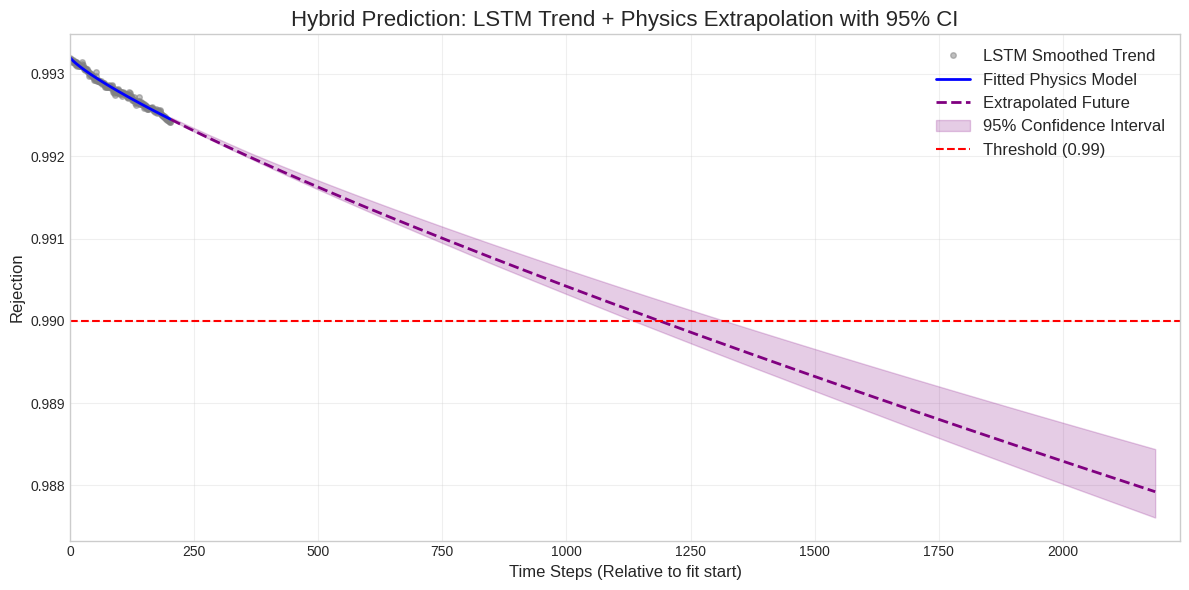


--- Time Estimation ---
Reference Time (Last Data): 2025-11-04 12:15:00
Predicted Remaining Useful Life (RUL): 8.21 hours
Predicted Failure Date: 2025-11-04 20:27:30


In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# =============================================================================
# 10. METHOD 2: CURVE FITTING & EXTRAPOLATION (with 95% CI)
# =============================================================================
print("\n--- [Method 2] Physics-based Curve Fitting & Extrapolation (with CI) ---")

# ==========================================
# 1. Setup and Placeholder Function Definition
# ==========================================
threshold = 0.990   # Target Threshold (End-of-life limit)
fit_lookback = int(len(final_predictions) * 0.1)   # Number of recent LSTM prediction points to use for fitting
# fit_lookback = max(fit_lookback, 30) # Ensure minimum points

# Power Law Model Function
def fouling_model(t, a, b, c):
    return a - b * (t ** c)

# ==========================================
# 2. Data Preparation
# ==========================================
y_trend = final_predictions[-fit_lookback:].flatten()
x_trend = np.arange(len(y_trend))

print(f"Fitting physics model to the last {fit_lookback} points of LSTM predictions...")

popt = None
pcov = None
lower_ci, upper_ci = None, None

try:
    # Initial guess
    initial_guess = [0.05, 0.0001, 0.95]

    # Bounds
    lower_bounds = [0, 1e-9, 0]
    upper_bounds = [np.inf, np.inf, 1.5]

    popt, pcov = curve_fit(
        fouling_model, x_trend, y_trend,
        p0=initial_guess,
        bounds=(lower_bounds, upper_bounds),
        maxfev=10000
    )

    print(f"Fitting Successful!")
    print(f"Estimated Parameters: a={popt[0]:.4e}, b={popt[1]:.4e}, c={popt[2]:.4f}")

    if popt[1] < 1e-7:
        print("Warning: Decay rate is still very slow. The trend might be too flat.")

except Exception as e:
    print(f"Fitting Failed: {e}")
    popt = None

# ==========================================
# 4. Future Prediction (Extrapolation) & CI Calculation
# ==========================================
steps_to_threshold = -1
forecast_plot_values = []
max_forecast_steps = 400000
start_t = len(y_trend)

if popt is not None:
    # (A) Mean Prediction Line
    future_steps_range = np.arange(start_t, start_t + max_forecast_steps)
    forecast_plot_values = fouling_model(future_steps_range, *popt)

    # Check if Threshold is reached
    reached_indices = np.where(forecast_plot_values <= threshold)[0]

    if len(reached_indices) > 0:
        first_reach_idx = reached_indices[0]
        steps_to_threshold = first_reach_idx + 1

        display_margin = 1000
        cut_idx = first_reach_idx + display_margin
        forecast_plot_values = forecast_plot_values[:cut_idx]
        future_steps_range = future_steps_range[:cut_idx]

        print(f"\n[Result] Threshold ({threshold}) reached in {steps_to_threshold} steps.")
        print(f"Final Value: {forecast_plot_values[first_reach_idx]:.4f}")
    else:
        print(f"\n[Result] Threshold not reached within {max_forecast_steps} steps.")

    # (B) Calculate 95% Confidence Intervals (CI) - Monte Carlo
    print("Calculating 95% Confidence Intervals...")
    num_samples = 500
    try:
        params_samples = np.random.multivariate_normal(popt, pcov, num_samples)
        simulated_curves = []
        for params in params_samples:
            if (np.any(params < lower_bounds) or np.any(params > upper_bounds)):
                continue
            sim_curve = fouling_model(future_steps_range, *params)
            simulated_curves.append(sim_curve)

        if len(simulated_curves) > 0:
            simulated_curves = np.array(simulated_curves)
            lower_ci = np.percentile(simulated_curves, 2.5, axis=0)
            upper_ci = np.percentile(simulated_curves, 97.5, axis=0)
    except Exception as e:
        print(f"CI Calculation Warning: Could not generate intervals ({e})")

# ==========================================
# 5. Result Visualization
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

# (1) LSTM Trend
ax.plot(range(len(y_trend)), y_trend, 'o', color='gray', label='LSTM Smoothed Trend', markersize=4, alpha=0.5)

if popt is not None:
    # (2) Fitted Curve
    fitted_curve = fouling_model(x_trend, *popt)
    ax.plot(x_trend, fitted_curve, '-', color='blue', linewidth=2, label='Fitted Physics Model')

    # (3) Future Extrapolation
    if len(forecast_plot_values) > 0:
        ax.plot(future_steps_range, forecast_plot_values, '--', color='purple', label='Extrapolated Future', linewidth=2)

        # (3-1) 95% CI Area
        if lower_ci is not None and upper_ci is not None:
            ax.fill_between(
                future_steps_range,
                lower_ci,
                upper_ci,
                color='purple',
                alpha=0.2,
                label='95% Confidence Interval'
            )

ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
ax.set_title('Hybrid Prediction: LSTM Trend + Physics Extrapolation with 95% CI', fontsize=16)
ax.set_xlabel('Time Steps (Relative to fit start)', fontsize=12)
ax.set_ylabel('Rejection', fontsize=12)

if steps_to_threshold != -1:
    ax.set_xlim(0, future_steps_range[-1] + 50)
else:
    ax.set_xlim(0, len(y_trend) + 1000)

ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==========================================
# 6. Time Conversion (Steps -> Real Time) [Modified]
# ==========================================
if steps_to_threshold != -1:
    # [Modified] Since 'time_diff' column is missing, use the resampled interval directly
    median_time_step_minutes = 0.5

    # Last data timestamp
    last_timestamp = df_final.index[-1]

    # Calculate remaining time
    time_to_threshold = pd.Timedelta(minutes=(steps_to_threshold * median_time_step_minutes))
    hours_taken = steps_to_threshold * median_time_step_minutes / 60

    # Estimated failure date
    predicted_timestamp = last_timestamp + time_to_threshold

    print("\n--- Time Estimation ---")
    print(f"Reference Time (Last Data): {last_timestamp}")
    print(f"Predicted Remaining Useful Life (RUL): {hours_taken:.2f} hours")
    print(f"Predicted Failure Date: {predicted_timestamp}")